In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [53]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

wine = pd.read_csv(url,sep=';')

# remove some rows with outliers
data = wine[wine['total sulfur dioxide']<200]

wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


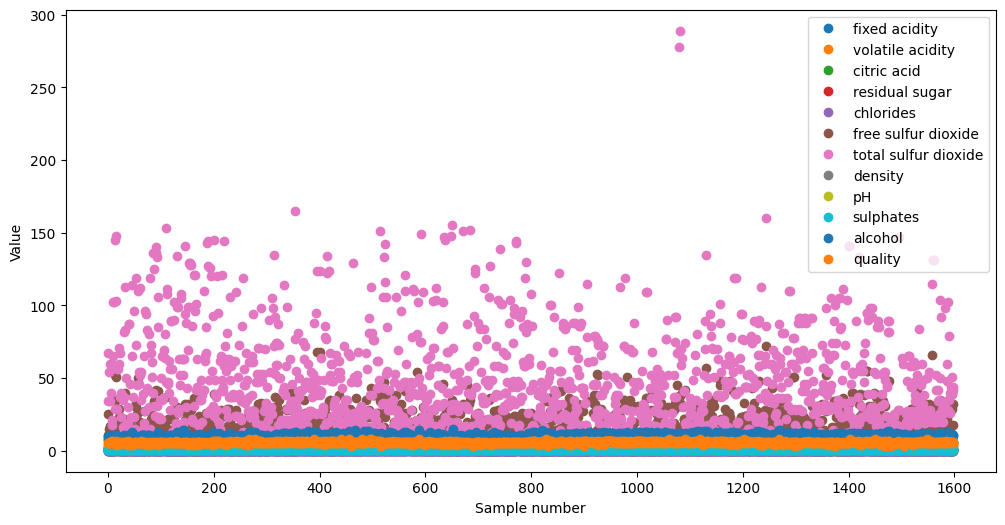

In [54]:
# plot the data
wine.plot(marker='o', linestyle='none', figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [55]:
input_columns = wine.keys().drop('quality')
wine[input_columns] = wine[input_columns].apply(stats.zscore)

# binarize quality to simplify the model
wine['bool_quality'] = 0
wine['bool_quality'][wine['quality']>5] = 1

# convert from pandas dataframe to tensor
data_tensor  = torch.tensor(wine[input_columns].values).float()
labels = torch.tensor(wine['bool_quality'].values).float()
labels = labels[:,None]  # transform to matrix

data_tensor, labels

/tmp/ipykernel_18783/1065330747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine['bool_quality'][wine['quality']>5] = 1


(tensor([[-0.5284,  0.9619, -1.3915,  ...,  1.2886, -0.5792, -0.9602],
         [-0.2985,  1.9674, -1.3915,  ..., -0.7199,  0.1290, -0.5848],
         [-0.2985,  1.2971, -1.1861,  ..., -0.3312, -0.0481, -0.5848],
         ...,
         [-1.1603, -0.0996, -0.7239,  ...,  0.7055,  0.5420,  0.5416],
         [-1.3902,  0.6546, -0.7753,  ...,  1.6774,  0.3060, -0.2093],
         [-1.3327, -1.2168,  1.0220,  ...,  0.5111,  0.0109,  0.5416]]),
 tensor([[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [0.],
         [1.]]))

# Break the data into batches

In [56]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)


# finally, translate into dataloader objects
def load_train_data_batches_with_multipliers(batch_multipliers):
    batch_size_base = 2
    for multiplier in batch_multipliers:
        yield DataLoader(train_data, batch_size=batch_size_base**multiplier, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

In [57]:
# check sizes of data batches
for batch in load_train_data_batches_with_multipliers([1, 3, 5, 7, 9]):
    print("batch_size =", batch.batch_size)
    for X, y in batch:
        print(X.shape, y.shape)


batch_size = 2
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size([2, 11]) torch.Size([2, 1])
torch.Size

# Construct the model and training plans

In [58]:
class ANNMultilayer(nn.Module):
    def __init__(self):
        super().__init__()
        # model architecture
        self._input = nn.Linear(11, 16)
        self._hidden1 = nn.Linear(16, 32)
        self._hidden2 = nn.Linear(32, 32)
        self._output = nn.Linear(32, 1)

    def forward(self, input):
        x = F.relu(self._input(input))
        x = F.relu(self._hidden1(x))
        x = F.relu(self._hidden2(x))
        return self._output(x)

In [59]:
class ANNPipeline():
    def __init__(self, learning_rate):
        self._ann = ANNMultilayer()
        # loss function
        self._lossfun = nn.BCEWithLogitsLoss()
        # optimizer
        self._optimizer = torch.optim.SGD(self._ann.parameters(), lr=learning_rate)

    def train(self, train_loader, numepochs=1000):
        # initialize accuracies as empties
        train_accuracy = []
        test_accuracy = []
        losses = torch.zeros(numepochs)

        for epochi in range(numepochs):
            self._ann.train()
            # loop over training data batches
            batchAcc = []
            batchLoss = []
            for X, y in train_loader:
                # forward pass and loss
                yHat = self._ann(X)
                loss = self._lossfun(yHat, y)

                # backprop
                self._optimizer.zero_grad()
                loss.backward()
                self._optimizer.step()

                # compute training accuracy just for this batch
                batchAcc.append(100*torch.mean(((yHat>0) == y).float()).item())
                batchLoss.append(loss.item())
            # end of batch loop...

            # now that we've trained through the batches, get their average training accuracy
            train_accuracy.append(np.mean(batchAcc))
            losses[epochi] = np.mean(batchLoss)

            # test accuracy
            self._ann.eval()
            X, y = next(iter(test_loader)) # extract X,y from test dataloader
            with torch.no_grad():
                yHat = self._ann(X)
            train_accuracy.append(100*torch.mean(((yHat>0) == y).float()).item())

        # function output
        return train_accuracy, test_accuracy, losses

# Test it out

In [60]:
result_data = {}
for train_loader in load_train_data_batches_with_multipliers(batch_multipliers=[1, 2, 3, 4, 5, 6]):
    net = ANNPipeline(learning_rate=.01)
    train_accuracy, test_accuracy, losses = net.train(train_loader)
    result_data[train_loader.batch_size] = {
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "losses": losses
    }

In [61]:
result_data

{2: {'train_accuracy': [50.46948356807512,
   52.812498807907104,
   62.20657276995305,
   75.62500238418579,
   72.30046948356808,
   74.06250238418579,
   74.1001564945227,
   75.93749761581421,
   74.17840375586854,
   76.2499988079071,
   74.33489827856025,
   74.6874988079071,
   75.43035993740219,
   77.8124988079071,
   76.21283255086072,
   75.93749761581421,
   76.21283255086072,
   77.18750238418579,
   77.54303599374022,
   77.49999761581421,
   76.83881064162755,
   78.75000238418579,
   75.8998435054773,
   74.37499761581421,
   76.99530516431925,
   75.0,
   77.15179968701095,
   76.2499988079071,
   77.54303599374022,
   76.5625,
   77.77777777777777,
   77.8124988079071,
   77.54303599374022,
   77.49999761581421,
   78.09076682316119,
   77.18750238418579,
   77.93427230046949,
   79.06249761581421,
   77.93427230046949,
   76.2499988079071,
   77.38654147104852,
   77.18750238418579,
   78.24726134585289,
   76.8750011920929,
   77.85602503912364,
   76.2499988079071,

2 {'train_accuracy': [50.46948356807512, 52.812498807907104, 62.20657276995305, 75.62500238418579, 72.30046948356808, 74.06250238418579, 74.1001564945227, 75.93749761581421, 74.17840375586854, 76.2499988079071, 74.33489827856025, 74.6874988079071, 75.43035993740219, 77.8124988079071, 76.21283255086072, 75.93749761581421, 76.21283255086072, 77.18750238418579, 77.54303599374022, 77.49999761581421, 76.83881064162755, 78.75000238418579, 75.8998435054773, 74.37499761581421, 76.99530516431925, 75.0, 77.15179968701095, 76.2499988079071, 77.54303599374022, 76.5625, 77.77777777777777, 77.8124988079071, 77.54303599374022, 77.49999761581421, 78.09076682316119, 77.18750238418579, 77.93427230046949, 79.06249761581421, 77.93427230046949, 76.2499988079071, 77.38654147104852, 77.18750238418579, 78.24726134585289, 76.8750011920929, 77.85602503912364, 76.2499988079071, 78.95148669796558, 73.1249988079071, 79.34272300469483, 76.2499988079071, 78.87323943661971, 75.3125011920929, 79.18622848200313, 72.812

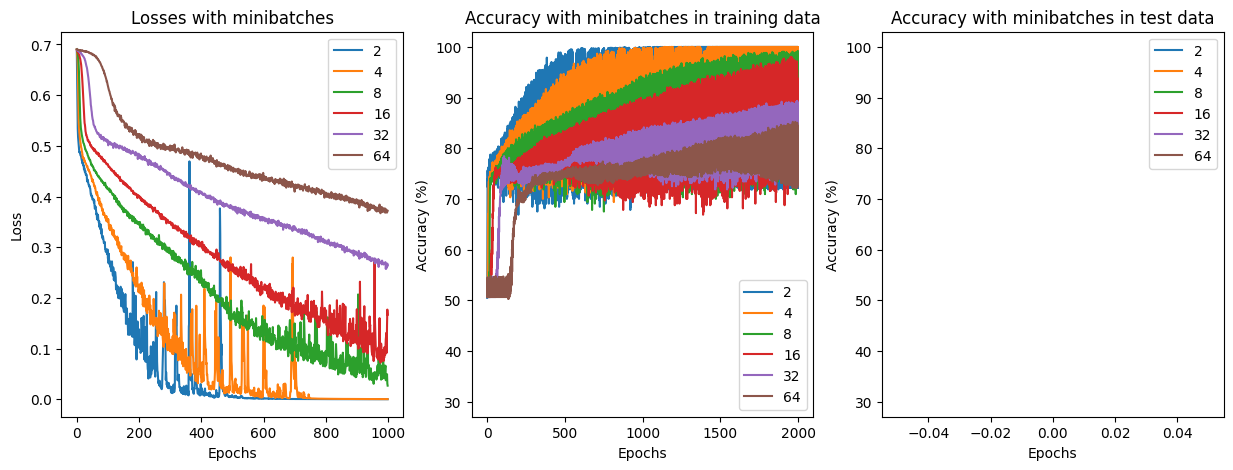

In [62]:
# plot the results
fig, ax = plt.subplots(1,3,figsize=(15,5))


for batch_size, results in result_data.items():
    ax[0].plot(results["losses"])
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatches')
ax[0].legend([batch_size for batch_size in result_data])

for batch_size, results in result_data.items():
    ax[1].plot(results["train_accuracy"])
ax[1].set_title('Accuracy with minibatches in training data')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend([batch_size for batch_size in result_data])
ax[1].set_ylim([27,103])

for batch_size, results in result_data.items():
    print(batch_size, results)
    ax[2].plot(results["test_accuracy"])
ax[2].set_title('Accuracy with minibatches in test data')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy (%)')
ax[2].legend([batch_size for batch_size in result_data])
ax[2].set_ylim([27,103])

plt.show()